In [18]:
from pandas import DataFrame, read_csv
from tqdm import tqdm

games_df = read_csv("./data/01-11-processed.csv")
games_df = games_df.dropna()

print(games_df.shape)

from sklearn.model_selection import train_test_split

feature_cols = ["PL5G", "OL5G", "PS", "OS", "PWR", "OWR", "AWR", "ABD"]

X = games_df[feature_cols]
y = games_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1000)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))



(91608, 16)
0.6510348441184176


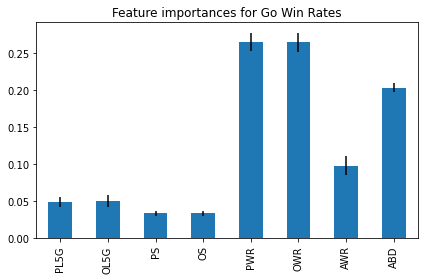

In [2]:
from matplotlib import pyplot
from numpy import std
from pandas import Series

std = std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = Series(forest.feature_importances_, index=feature_cols)

fig, ax = pyplot.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for Go Win Rates")
fig.tight_layout()

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[7585, 3999],
       [3893, 7425]])

In [ ]:
count = 0
for i, prediction, label in zip(X_test.iterrows(), y_pred, y_test):
    if prediction != label and not 0.4 <= i[1].AWR <= 0.6:
        count += 1

count

In [ ]:
rfc = RandomForestClassifier()
parameters = {"n_estimators": [500, 1000], "max_depth": [2, 4, 8, 16, 32, None]}

from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(rfc, parameters, cv=5)
cv.fit(X_train, y_train)

In [ ]:
def display(results):
    print(f"Best parameters are: {results.best_params_}")
    print("\n")
    mean_score = results.cv_results_["mean_test_score"]
    std_score = results.cv_results_["std_test_score"]
    params = results.cv_results_["params"]
    for mean, std, params in zip(mean_score, std_score, params):
        print(f"{round(mean,3)} + or -{round(std,3)} for the {params}")


display(cv)

In [ ]:
forest = RandomForestClassifier(n_estimators=50, max_depth=8)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

In [15]:
from pandas import DataFrame, read_csv

games_df = read_csv("./data/01-11-processed.csv")
games_df = games_df.dropna()

from sklearn.model_selection import train_test_split

feature_cols = [
    "PL5G",
    "OL5G",
    "PS",
    "OS",
    "PWR",
    "OWR",
    "AWR",
]

X = games_df[feature_cols]
y = games_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn import metrics, svm

machine = svm.SVC()

machine.fit(X_train, y_train)
y_pred = machine.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.6660117020347568
